# 유용한 변수 선택하기 (Feature selection)

## 실습 개요
유용한 변수 선택하기 (Feature selection)


1) 실습 목적
 * 실제 주가 데이터셋(OHLCV)의 파생 변수들 중 유용한 변수들을 여러가지 방법으로 선택해보는 실습을 진행합니다.
 * Feature importance 기반 선택, Forward selection 기반의 선택에서 관련 API를 사용해보고 여러가지 방법마다 선택되는 변수가 다를 수 있음을 이해합니다.


2) 수강 목표
 * 여러가지 방법을 이용해 상황에 맞게 유용한 변수를 선택할 수 있습니다.
 * 변수 선택 방법에 따라 선택되는 변수가 다름을 이해할 수 있습니다.

### 실습 목차

- **1. 데이터 준비**
  - 1-1 실습 데이터 구성하기
  - 1-2 데이터셋 분할
- **2. Feature selection 구현**
  - 2.1 Forward selection, Backward elimination
  - 2.2 Feature importance 기반 selection
  - 2.3 Permutation importance 기반 selection




### 데이터셋 개요
* 데이터셋: Yahoo Finance OHLCV 데이터셋이란? (Open High Close Low Volume)
* 데이터셋 개요 : **Yahoo Finance는 주식, 환율과 같은 금융 정보를 제공하는 플랫폼입니다.** 주식과 관련된 정보 및 시각화 정보를 웹사이트를 통해서 제공 (NASDAQ, KOSPI, NIKKEI 등) 됩니다. 데이터는 무료로 사용할 수 있으며, API를 제공하여 손쉽게 데이터를 수집 가능합니다. 또한, Yahoo Finance 정보를 랩핑한 yfinance 패키지를 이용해 파이썬에서도 사용 가능합니다.
  - (O)pen (시가): 주식의 거래가 시작된 가격을 나타냅니다. 시장이 열리면 처음으로 발생한 거래의 가격입니다.
  - (H)igh (고가): 특정 기간 동안 주식의 가격 중 최고점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 높게 거래되었는지를 보여줍니다.
  - (C)lose (종가): 주식의 거래가 마감된 가격을 나타냅니다. 시장이 닫힐 때 주식이 어떤 가격으로 거래를 마쳤는지를 보여줍니다.
  - (L)ow (저가): 특정 기간 동안 주식의 가격 중 최저점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 낮게 거래되었는지를 보여줍니다.
  - (V)Volume (거래량):  특정 기간 동안 거래된 주식의 총 수량을 나타냅니다. 거래량은 주식 시장에서 매우 중요한 지표 중 하나이며, 주식의 유동성과 관련이 있습니다. 더 높은 거래량은 주식 시장의 활발한 거래를 나타낼 수 있습니다.
  - Change (변동률): 이전 주가와 비교해 변화된 변동률 입니다.
  - code (종목 코드): 종목(회사)를 구분하는 코드입니다.
* 데이터셋 저작권 : Apache Software License (Apache)


### 환경 설정

- **패키지 설치 및 임포트**

In [3]:
!pip install eli5==0.13.0
!pip install gdown==4.7.1
!pip install lightgbm==4.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.5 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107729 sha256=e1f89aace2b3be5367fd7c5b6048436c282481d4654265391ae93e2c358cb4e5
  Stored in directory: /Users/myeongjinlee/Library/Caches/pip/wheels/ec/68/a9/de7d374ecb6f53462ce0eec8326fbab91b6228c82e67428d0d
Successfully built eli5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.0.0-py3-none-macosx_13_0_arm64.whl size=1369159 sha256=2a93d0ac543428559111385099e4f5b28c5d90f7eca96bebe2de197b1f1c792f
  Stored in directory: /Users/myeongjinlee/Library/Caches

In [6]:
# 계산
import numpy as np
import time

# 데이터셋 로드 및 정제
import gdown
import pandas as pd

# 출력 및 시각화
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# 전처리
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# 모델
import statsmodels.api as sm
import eli5
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from eli5.sklearn import PermutationImportance

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.feature_selection import SelectFromModel

# 평가
from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_auc_score

# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

## 1. 데이터 준비
```
💡 목차 개요 : 실습 데이터 준비
```
- **1-1 실습 데이터 구성하기**
- **1-2 데이터셋 분할**


### 1-1 실습 데이터 구성하기

#### 📝 설명 : (1-1)
> Feature selection은 모델을 제작할 때 학습에 도움 되는 특성(Feature) 선택하는 과정입니다. <br>
다르게 생각해보면, 모델 학습에 불필요한 변수를 생략하는 과정으로도 이해할 수 있습니다. <br>
이번 실습에 필요한 주가 관련 데이터(OHLCV)를 불러오고, 파생 변수 제작 및 정제를 하겠습니다.

#### 👨‍💻 코드 : (1-1)

In [7]:
# OHLCV 데이터셋 불러오기
file_path = "/Users/myeongjinlee/Desktop/UPSTAGE AI/ml advanced"
OHCLV_file = "[ML Advanced] 실습용 데이터 셋 - OHCLV.parquet"

OHLCV_data = pd.read_parquet(f"{file_path}/{OHCLV_file}")

# 날짜는 데이터셋의 index로 되어 있습니다.
# .loc을 통해서 날짜 범위를 지정해줍시다.
OHLCV_data = OHLCV_data.sort_index()
OHLCV_data = OHLCV_data.loc["2020-01-01":"2023-07-31"]

# 상장법인정보 파일도 불러오도록 하겠습니다.
company_file = "[ML Advanced] 실습용 데이터 셋 - Company.parquet"
company_data =  pd.read_parquet(f"{file_path}/{company_file}")

In [8]:
# OHLCV은 종목별 주가와 관련된 정보를 나타내는 데이터셋입니다.
display(OHLCV_data.head(10))

# 상장법인정보 데이터셋입니다.
display(company_data.head(10))

,Open,High,Low,Close,Volume,Change,code
2020-01-02,7037.0,7123.0,7018.0,7106.0,13986.0,0.009518,001530
2020-01-02,31400.0,32350.0,31100.0,32100.0,75206.0,0.033816,003350
2020-01-02,7300.0,7450.0,7270.0,7340.0,60800.0,0.009629,005870
2020-01-02,1165.0,1180.0,1160.0,1175.0,117291.0,0.008584,006340
2020-01-02,95100.0,95200.0,91800.0,91900.0,250460.0,-0.035677,010950
2020-01-02,77800.0,78900.0,77200.0,77700.0,3389.0,-0.001285,02826K
2020-01-02,769000.0,771000.0,757000.0,770000.0,1023.0,-0.001297,051905
2020-01-02,11600.0,11750.0,11400.0,11400.0,1549105.0,-0.017241,316140
2020-01-02,427932.0,434356.0,420520.0,423485.0,109563.0,-0.010392,207940
2020-01-02,90400.0,92300.0,89100.0,91900.0,20863.0,0.027964,090435


,company,code,industry,products,listing_date,closing_month,region
0,시지트로닉스,429270,반도체 제조업,특화반도체 소자,2023-08-03,12월,전라북도
1,에피바이오텍,446440,자연과학 및 공학 연구개발업,탈모 치료제,2023-07-31,12월,인천광역시
2,조선내화,462520,"내화, 비내화 요업제품 제조업",내화 요업제품,2023-07-28,12월,전라남도
3,에이엘티,172670,반도체 제조업,반도체 테스트 및 패키징(반도체 후공정),2023-07-27,12월,충청북도
4,유안타제14호스팩,450940,금융 지원 서비스업,금융 지원 서비스,2023-07-27,12월,서울특별시
5,파로스아이바이오,388870,자연과학 및 공학 연구개발업,PHI-101 급성골수성백혈병 치료제 및 재발성난소암 치료제,2023-07-27,12월,경기도
6,길교이앤씨,456700,"건축기술, 엔지니어링 및 관련 기술 서비스업",강합성 라멘교,2023-07-26,12월,경상북도
7,버넥트,438700,소프트웨어 개발 및 공급업,산업용 XR 솔루션,2023-07-26,12월,서울특별시
8,뷰티스킨,406820,기타 화학제품 제조업,"화장품 제조, 브랜드, 유통 사업",2023-07-24,12월,인천광역시
9,SK증권제9호스팩,455910,금융 지원 서비스업,기업인수목적회사,2023-07-21,12월,서울특별시


- 이번 실습을 시작하기 전에 우리는 크게 두 가지 성향의 파생 변수를 만들고 시작할거에요.
- 첫 번째는 금융 도메인 지식에 기반해서 파생 변수를 만들고 시작할게요!
- 자칫 어려울수도 있으나, 주가 관련한 금융 도메인에서는 이런 파생 변수가 존재하는걸 인지만하시고 넘어가시면 됩니다.

In [9]:
# 현재 데이터프레임의 인덱스가 날짜로 되어있습니다.
# 분석 편의를 위해서 Date컬럼을 새로 만들고, 인덱스는 새로 초기화 하겠습니다.
OHLCV_data["Date"] = OHLCV_data.index
OHLCV_data["Date"] = pd.to_datetime(OHLCV_data["Date"])
OHLCV_data.reset_index(drop=True, inplace=True)

# 두 파일을 결합시켜 OHCLV와 상장법인정보를 함께 볼수 있도록 하겠습니다.
OHLCV_data = pd.merge(OHLCV_data, company_data, on="code", how="inner")

OHLCV_data["Target"] = OHLCV_data.groupby("code")["Close"].shift(-1)

# 파생 변수1 - 가격 차이를 구합시다.
OHLCV_data["PriceRange"] = OHLCV_data["High"] - OHLCV_data["Low"]
# 파생 변수2 - 종목의 대푯값인 평균 가격를 구합시다.
OHLCV_data["AveragePrice"] = (OHLCV_data["Open"] + OHLCV_data["High"] + OHLCV_data["Low"] - OHLCV_data["Close"]) / 4
# 파생 변수3 - 종가가 시가보다 크면 주가의 방향은 양(1)으로, 반대로 종가가 시가보다 작으면 음(-1)을 표현하도록 하겠습니다.
OHLCV_data['PriceDirection'] = OHLCV_data.apply(lambda row: 1 if row['Close'] > row['Open'] else -1, axis=1)
# 파생 변수4 - 일일 수익률을 계산합니다.
OHLCV_data['DailyReturn'] = OHLCV_data.groupby('code')['Close'].transform(lambda x: x.pct_change() * 100)
# 파생 변수5 - 장기, 중기, 단기 이동평균을 파생변수로 추가합니다.
OHLCV_data["MovingAverage5d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=5).mean())
OHLCV_data["MovingAverage20d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).mean())
OHLCV_data["MovingAverage60d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=60).mean())
OHLCV_data["MovingAverage120d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=120).mean())

# 파생 변수6 - 볼린저 밴드(Bolinger bands)는 이동 평균을 기준으로 상한, 하한 밴드를 구성하여 추세와 변동성을 파악하는 기술입니다.
# 표준편차에 대한 상한 및 하한 밴드의 배수 설정
std_multiplier = 2
std = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).std())
# 상한은 일반적으로 20일 이동평균에 2배의 표준편차 더하기
# 하한은 일반적으로 20일 이동평균에 2배의 표준편차 빼기
OHLCV_data["LowerBollingerBand"] = OHLCV_data["MovingAverage20d"] + (std_multiplier * std)
OHLCV_data["UpperBollingerBand"] = OHLCV_data["MovingAverage20d"] - (std_multiplier * std)

# 파생 변수7 - MACD (Moving Average Convergence & Divergence)는 추가 추세의 힘과 방향성을 파악하여 매매신호를 잡는 목적으로 사용됩니다.
OHLCV_data['ShortEMA'] = OHLCV_data["Close"].ewm(span=12, adjust=False).mean()
OHLCV_data['LongEMA'] = OHLCV_data["Close"].ewm(span=26, adjust=False).mean()
OHLCV_data['MACD'] = OHLCV_data['ShortEMA'] - OHLCV_data['LongEMA']

- 두 번째는 상장법인정보를 기반으로 만들어볼거에요!
- 업종(industry), 주요 제품(products), 상장일(listing_date) 등을 결합해서 새로운 파생 변수를 만들어보도록 하겠습니다.

In [10]:
# 파생 변수8 - OHLCV컬럼 모두 업종별로 일일 평균, 중앙값을 집계해보겠습니다.
# 일별, 업종별로 집계를 해야하기 때문에 두개의 변수(Date, industry)가 집계요소로 들어갑니다.
# 일별 시가의 평균, 중앙값
open_stats = OHLCV_data.groupby(["Date", "industry"])["Open"].agg(["mean", "median"])
open_stats.columns = ["OpenMean", "OpenMedian"]
OHLCV_data = pd.merge(OHLCV_data, open_stats, how="inner", on=["industry", "Date"])
# 일별 고가의 평균, 중앙값
high_stats = OHLCV_data.groupby(["Date", "industry"])["High"].agg(["mean", "median"])
high_stats.columns = ["HighMean", "HighMedian"]
OHLCV_data = pd.merge(OHLCV_data, high_stats, how="inner", on=["industry", "Date"])
# 일별 저가의 평균, 중앙값
low_stats = OHLCV_data.groupby(["Date", "industry"])["Low"].agg(["mean", "median"])
low_stats.columns = ["LowMean", "LowMedian"]
OHLCV_data = pd.merge(OHLCV_data, low_stats, how="inner", on=["industry", "Date"])
# 일별 종가의 평균, 중앙값
close_stats = OHLCV_data.groupby(["Date", "industry"])["Close"].agg(["mean", "median"])
close_stats.columns = ["CloseMean", "CloseMedian"]
OHLCV_data = pd.merge(OHLCV_data, close_stats, how="inner", on=["industry", "Date"])
# 일별 거래량의 평균, 중앙값
volume_stats = OHLCV_data.groupby(["Date", "industry"])["Volume"].agg(["mean", "median"])
volume_stats.columns = ["VolumeMean", "VolumeMedian"]
OHLCV_data = pd.merge(OHLCV_data, volume_stats, how="inner", on=["industry", "Date"])

# 파생 변수 9 - 시간관련 파생 변수
# Date, listing_date컬럼은 "2020-01-01" 형태로 되어있어요.
# 이걸 컴퓨터가 인식할 수 있도록 년,월,일 정수 컬럼으로 나눠서 표현해볼게요.
# Date컬럼 나누기
OHLCV_data["DateYear"] = OHLCV_data["Date"].dt.year
OHLCV_data["DateMonth"] = OHLCV_data["Date"].dt.month
OHLCV_data["DateDay"] = OHLCV_data["Date"].dt.day
# listing_date컬럼 나누기
OHLCV_data["ListingDateYear"] = OHLCV_data["listing_date"].dt.year
OHLCV_data["ListingDateMonth"] = OHLCV_data["listing_date"].dt.month
OHLCV_data["ListingDateDay"] = OHLCV_data["listing_date"].dt.day
# closing_month컬럼은 "12월" 형태이기 때문에 "월"을 빼고 정수만 남기도록 할게요.
OHLCV_data["ClosingMonthInt"] = OHLCV_data["closing_month"].str.replace('월', '').astype(int)

- 학습을 위해서 범주형 변수를 인코딩 하는 작업을 하겠습니다.
- Label Encoding, Frequency Encdoing, Target Encoding

In [11]:
# Label Encoding을 진행합니다.
# sklearn에서 제공하는 LabelEncoder를 활용합시다.
label_encoder = LabelEncoder()

OHLCV_data["LEncodedIndustry"] = label_encoder.fit_transform(OHLCV_data["industry"])
OHLCV_data["LEncodedProducts"] = label_encoder.fit_transform(OHLCV_data["products"])
OHLCV_data["LEncodedRegion"] = label_encoder.fit_transform(OHLCV_data["region"])

# Frequency Encoding을 진행합니다.
frequency_encoder = OHLCV_data["industry"].value_counts()
OHLCV_data['FEncodedIndustry'] = OHLCV_data['industry'].map(frequency_encoder)

# Target Encoding을 진행합니다.
# 각 업종별 종가의 평균 계산
target_encoder = OHLCV_data.groupby("industry")["Close"].mean()
OHLCV_data["TEncodedIndustry"] = OHLCV_data['industry'].map(target_encoder)

- 마지막으로 결측치와 학습에 불필요한 컬럼들은 모두 제거하겠습니다.

In [12]:
# 결측치 모두 제거
OHLCV_data.dropna(inplace=True)

# OHLCV의 0이 되는 이상치 및 결측치는 모두 제거
OHLCV_data = OHLCV_data[(OHLCV_data[["Open", "High", "Low", "Close", "Volume", "Change"]] != 0).all(axis=1)]

OHLCV_data.drop([
    "company", "industry",
    "products", "listing_date", "closing_month",
    "region", "code"
    ], axis=1, inplace=True)

OHLCV_data.reset_index(drop=True, inplace=True)

### 1-2 데이터셋 분할

📝 설명 : (1-2)
- 주어진 주가(OHLCV) 데이터셋은 시계열 특성을 띄고있습니다.
- 일반적 방법인 학습(Train) 및 검증(Valid) 데이터셋으로 분할하게 되면, 분석 및 모델링에 문제가 발생할 수 있습니다.
- 따라서, 마지막 3개월을 기준으로 학습과 검증 데이터셋으로 분할 하도록 하겠습니다.
- 분할 후 불필요한 컬럼들은 제거하도록 하겠습니다.

#### 👨‍💻 코드 : (1-2)

In [13]:
train_data = OHLCV_data.loc[OHLCV_data["Date"] < "2023-05-01"].reset_index(drop=True)
valid_data = OHLCV_data.loc[OHLCV_data["Date"] >= "2023-05-01"].reset_index(drop=True)

# Date 컬럼은 이제 필요가 없으니 제거하겠습니다.
train_data.drop("Date", axis=1, inplace=True)
valid_data.drop("Date", axis=1, inplace=True)

display(f"학습세트 : {len(train_data)} 개")
display(f"검증세트 : {len(valid_data)} 개")

'학습세트 : 515714 개'

'검증세트 : 45979 개'

In [14]:
# Target컬럼을 학습 데이터셋에서 제거하도록 하겠습니다.
target_col = "Target"
input_cols = list(train_data.columns)
input_cols.remove(target_col)

display(f"Input Featrue : {input_cols}")
display(f"Target : {target_col}")
print("\n")

# 시계열 데이터이기 때문에 인덱스를 기준으로 train/valid를 분할합니다. (랜덤으로 분할하지 않도록 주의하세요!)
X_train = train_data[input_cols]
Y_train = train_data[target_col]

X_valid = valid_data[input_cols]
Y_valid = valid_data[target_col]

display("학습에 사용할 최종 데이터의 형태는 아래와 같습니다.")
display(f"Train Input : {X_train.shape}")
display(f"Train Target : {Y_train.shape}")
display(f"Valid Input : {X_valid.shape}")
display(f"Valid Target : {Y_valid.shape}")

"Input Featrue : ['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'PriceRange', 'AveragePrice', 'PriceDirection', 'DailyReturn', 'MovingAverage5d', 'MovingAverage20d', 'MovingAverage60d', 'MovingAverage120d', 'LowerBollingerBand', 'UpperBollingerBand', 'ShortEMA', 'LongEMA', 'MACD', 'OpenMean', 'OpenMedian', 'HighMean', 'HighMedian', 'LowMean', 'LowMedian', 'CloseMean', 'CloseMedian', 'VolumeMean', 'VolumeMedian', 'DateYear', 'DateMonth', 'DateDay', 'ListingDateYear', 'ListingDateMonth', 'ListingDateDay', 'ClosingMonthInt', 'LEncodedIndustry', 'LEncodedProducts', 'LEncodedRegion', 'FEncodedIndustry', 'TEncodedIndustry']"

'Target : Target'

'학습에 사용할 최종 데이터의 형태는 아래와 같습니다.'

'Train Input : (515714, 41)'

'Train Target : (515714,)'

'Valid Input : (45979, 41)'

'Valid Target : (45979,)'

## 2. Feature selection의 구현  
- Feature selection에 자주 쓰이는 방법에는 아래와 같은 방법이 있습니다.    
차근차근 구현해보겠습니다.


> [1] **Filter methods**
변수간의 통계적 관계를 평가해 변수의 중요도를 결정하는 방법
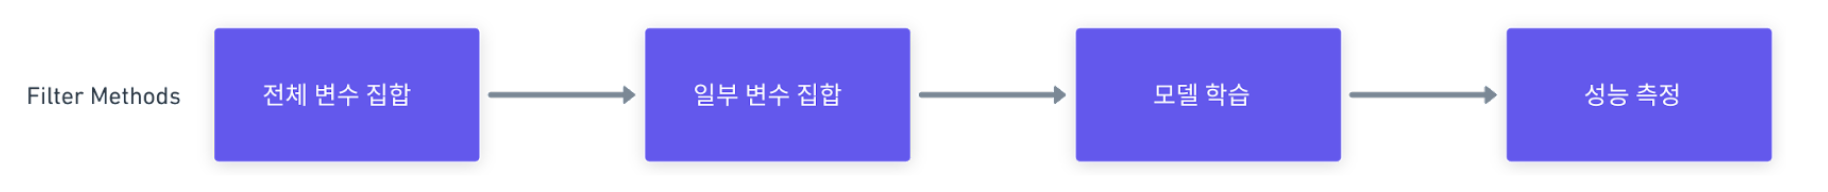
e.g. 상관성이 높은 Feature들을 찾아서 제거하는 방법 -> 상관계수 필요


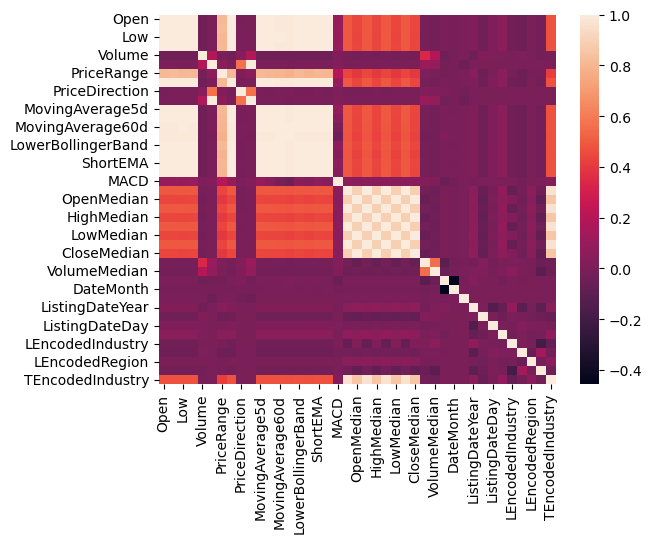

In [15]:
# 위 train data의 상관계수를 구해보겠습니다.
corr = X_train.corr()
sns.heatmap(corr);
plt.show()

### 2-1 Forward selection, Backward elimination


#### 📝 설명 : (2-1)
- 본래 forward selection은 아래 코드와 같이 회귀모델을 사용해 주로 구성됩니다.  
- 다만, 본 데이터는 시계열 특성이기 때문에 여러가지 특수한 상황을 가정해야 합니다.
- 이 때문에 바로 선형회귀 모델 (OLS)를 적용하기에는 어려움이 있을 수 있습니다.
- 그리고 앞서 확인한 독립변수간 상관계수도 매우 높은 편입니다.
- 따라서, feature selection을 진행하는 데에도 당연히 어려움이 있을 수 있습니다.
- 아래 코드는 참고만 해주세요!

```python
# 데이터와 타겟(목표 변수)을 입력으로 받고, 순방향 선택(forward selection)을 수행하는 함수입니다.
# 순방향 선택은 통계적인 모델(선형 회귀 모델)을 사용하여 가장 유의미한 독립 변수(특성)들을 선택하는 과정을 나타냅니다.
def forward_selection(data, target, significance_level=0.05):
    # 초기에는 모든 독립 변수(특성)가 후보에 포함되어 있습니다.
    initial_features = data.columns.tolist()
    # 선택된 최적의 독립 변수를 저장할 빈 리스트입니다.
    best_features = []
    best_rmse = float("inf")
    
    # 모든 독립 변수가 선택될 때까지 반복합니다.
    while (len(initial_features) > 0):
        # 아직 선택되지 않은 독립 변수 목록을 만듭니다.
        remaining_features = list(set(initial_features) - set(best_features))
        
        # 새로운 독립 변수가 추가될 때의 RMSE를 저장할 리스트를 생성합니다.
        rmse_list = []
        
        # 각각의 새로운 독립 변수에 대해 모델을 생성하고 RMSE를 계산합니다.
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features + [new_column]])).fit()
            predicted_values = model.predict(sm.add_constant(data[best_features + [new_column]]))
            rmse = sqrt(mean_squared_error(target, predicted_values))
            rmse_list.append(rmse)
        
        # 새로운 독립 변수 중에서 최소 RMSE를 찾습니다.
        min_rmse = min(rmse_list)
        
        # 최소 RMSE가 현재까지의 최적 RMSE보다 작으면 해당 독립 변수를 선택합니다.
        if (min_rmse < best_rmse):
            best_rmse = min_rmse
            best_features.append(remaining_features[rmse_list.index(min_rmse)])
        else:
            # 그렇지 않으면 루프를 종료합니다.
            break
    
    # 선택된 최적의 독립 변수 목록을 반환합니다.
    return best_features
```

- 기준 metric은 `RMSE`를 사용하겠습니다.

#### 👨‍💻 코드 : (2-1)

In [16]:
# 위와 같이 직접 구현하지 않고, 패키지 함수를 이용해 바로 진행할수도 있습니다.
sfs = SFS(DecisionTreeRegressor(max_depth=10, random_state=1214, min_samples_split=100), # 어떤 모델이든 들어갈 수 있습니다. 여기서는 기준 모델로 DecisionTree를 사용하겠습니다.
          forward=True, # forward = True이면 forward selection을 뜻합니다.
          floating=False,
          scoring="neg_root_mean_squared_error", # 기준이 될 성능 지표를 결정합니다. 여기서는 RMSE를 이용하겠습니다.
          cv=0,
          n_jobs=-1)

display(sfs)

SequentialFeatureSelector(cv=0,
                          estimator=DecisionTreeRegressor(max_depth=10,
                                                          min_samples_split=100,
                                                          random_state=1214),
                          n_jobs=-1, scoring='neg_root_mean_squared_error')

In [17]:
# 위에서 정의한 feature selection method를 학습시킵니다.
# 변수 선택 과정에서 모든 변수를 고려하기 때문에, feature의 개수에 따라 시간이 소요되니 유의하세요!
sfs.fit(X_train, Y_train)
display(sfs.k_feature_names_) # 선택된 feature를 반환합니다.

('Close',)

In [18]:
# 위에서 선택된 feature들로 모델 학습 후 결과를 관찰해 보겠습니다.

# 의사결정트리 분류기를 새로 초기화하고 중요한 특성만 사용하여 훈련합니다.
TP_X_train = X_train[['Close']]
TP_X_test = X_valid[['Close']]

start_time = time.time()
dt2 = DecisionTreeRegressor(max_depth=10, random_state=1214,min_samples_split=100)
dt2.fit(TP_X_train, Y_train)
y_pred = dt2.predict(TP_X_test)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"변수 선택 후 코드 실행 시간: {elapsed_time} 초")
y_true = Y_valid

# 제곱근 평균 제곱 오차 (RMSE) 계산
rmse = mean_squared_error(y_true, y_pred, squared=False)
print("변수 선택 후 RMSE:", rmse)

변수 선택 후 코드 실행 시간: 0.4154937267303467 초
변수 선택 후 RMSE: 2224.650646437113


- 역시나 backward elimination도 아래와 같이 회귀모델을 사용해 구성될 수 있습니다. 역시 아래 방법도 참고만 해주시면 감사하겠습니다.

```python
def backward_elimination(data, target, significance_level=0.05):
    features = data.columns.tolist()
    
    # 초기 RMSE를 설정합니다.
    best_rmse = 0
    
    # 모든 독립 변수가 사라질 때까지 반복합니다.
    while (len(features) > 0):
        # 현재 남아있는 독립 변수 중에서 각각을 제외한 RMSE를 저장할 리스트를 생성합니다.
        rmse_list = []
        
        for excluded_feature in features:
            remaining_features = list(set(features) - set([excluded_feature]))
            features_with_constant = sm.add_constant(data[remaining_features])
            model = sm.OLS(target, features_with_constant).fit()
            predicted_values = model.predict(features_with_constant)
            rmse = sqrt(mean_squared_error(target, predicted_values))
            rmse_list.append(rmse)
        
        # 최대 RMSE를 찾습니다.
        max_rmse = max(rmse_list)
        
        # 최대 RMSE가 현재까지의 최악의 RMSE보다 크면 해당 독립 변수를 제거합니다.
        if (max_rmse > best_rmse):
            worst_feature = features[rmse_list.index(max_rmse)]
            features.remove(worst_feature)
            best_rmse = max_rmse
        else:
            # 그렇지 않으면 루프를 종료합니다.
            break
    return features


```

> **[3] Embedded methods**
- 모델 훈련 과정에서 중요도를 평가해, 이를 기반으로 모델에 대한 변수 기여도를 결정하는 방법
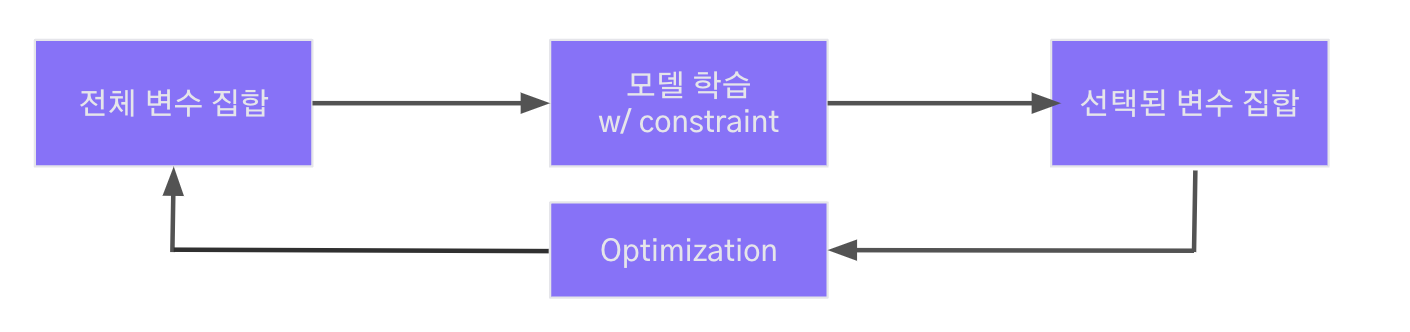


### 2-2 Feature importance 기반 selection

#### 📝 설명 : (2-2)
- 트리 node 분할에 대해 각 feature의 기여도로 각 변수의 중요성을 판단하는 방법
트리 split 기준 : Gini 계수, Entropy  
 → 학습 과정에서 feature의 기여도를 Importance에 따라 조절

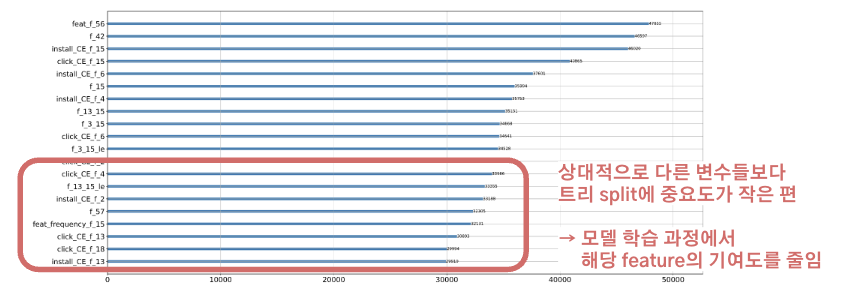

#### 👨‍💻 코드 : (2-2)

In [19]:
# 먼저 LGBM 모델을 학습시키겠습니다.
gbm = lgb.LGBMRegressor(n_estimators=100000,                # early stopping을 적용하기에 적당히 많은 반복 횟수를 지정합니다.
                        metric="rmse",
                        data_sample_strategy='goss',        # sampling 방법을 goss로 적용합니다.
                        max_depth=12,                       # default값인 20에서 12로 변경합니다.
                        num_leaves=62,                      # default값인 31에서 62으로 변경합니다.
                        min_data_in_leaf=40                 # default값인 20에서 40으로 변경합니다.
                        )

start_time = time.time()
gbm.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
        eval_metric ='rmse',
        categorical_feature="auto",
        callbacks=[lgb.early_stopping(stopping_rounds=50),         # early stopping을 적용합니다. 50번동안 metirc의 개선이 없다면 학습을 중단합니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]  # 10번의 반복마다 평가점수를 로그에 나타냅니다.
)
y_pred = gbm.predict(X_valid)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"변수 선택 전 코드 실행 시간: {elapsed_time} 초")

# 제곱근 평균 제곱 오차 (RMSE) 계산
y_true = Y_valid
rmse = mean_squared_error(y_true, y_pred, squared=False)
print("변수 선택 전 RMSE:", rmse)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7885
[LightGBM] [Info] Number of data points in the train set: 515714, number of used features: 41
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Start training from score 42008.865961
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 34835.8	valid_1's rmse: 29592.7
[20]	training's rmse: 12617.7	valid_1's rmse: 10865.1
[30]	training's rmse: 

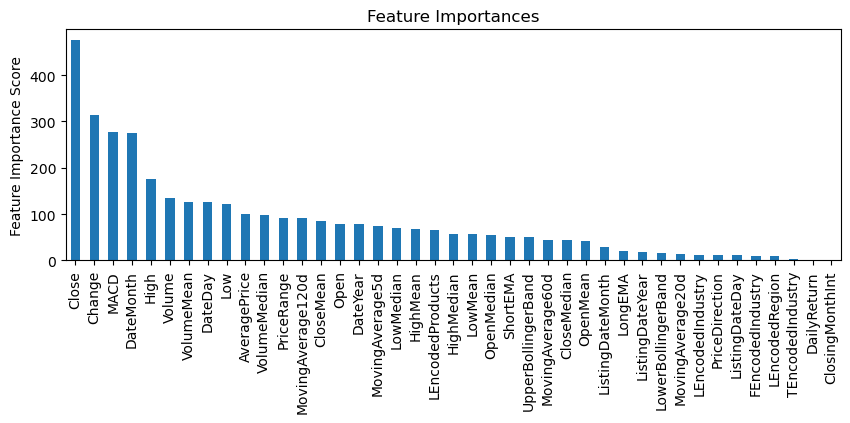

In [20]:
# 학습된 LGBM의 feature importance는 아래와 같습니다.
feat_imp = gbm.feature_importances_
sorted_feat_imp = pd.Series(feat_imp, input_cols).sort_values(ascending=False)
plt.figure(figsize=(10,3))
sorted_feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

In [21]:
# 위 importance를 이용해 importance가 100 이상인 변수들만 학습에 이용하겠습니다.

sfm = SelectFromModel(gbm, threshold=100, prefit = True)     # importance를 선정할 threshold를 설정합니다.
sfm.fit(X_train, Y_train) # 훈련 데이터를 사용하여 중요한 특성을 선택합니다.
X_important_train = sfm.transform(X_train)
X_important_valid = sfm.transform(X_valid)

start_time = time.time()
gbm = lgb.LGBMRegressor(n_estimators=100000,                # early stopping을 적용하기에 적당히 많은 반복 횟수를 지정합니다.
                        metric="rmse",
                        data_sample_strategy='goss',        # sampling 방법을 goss로 적용합니다.
                        max_depth=12,                       # default값인 20에서 12로 변경합니다.
                        num_leaves=62,                      # default값인 31에서 62으로 변경합니다.
                        min_data_in_leaf=40                 # default값인 20에서 40으로 변경합니다.
                        )

# 선택된 feature들로 재학습하겠습니다.
gbm.fit(X_important_train, Y_train,
        eval_set=[(X_important_train, Y_train), (X_important_valid, Y_valid)],
        eval_metric ='rmse',
        categorical_feature="auto",
        callbacks=[lgb.early_stopping(stopping_rounds=50),         # early stopping을 적용합니다. 50번동안 metirc의 개선이 없다면 학습을 중단합니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]  # 10번의 반복마다 평가점수를 로그에 나타냅니다.
)

y_pred = gbm.predict(X_important_valid)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"변수 선택 후 코드 실행 시간: {elapsed_time} 초")

y_true = Y_valid

# 제곱근 평균 제곱 오차 (RMSE) 계산
rmse = mean_squared_error(y_true, y_pred, squared=False)
print("변수 선택 후 RMSE:", rmse)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 515714, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Start training from score 42008.865961
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 36042.1	valid_1's rmse: 29497.9
[20]	training's rmse: 15447.4	valid_1's rmse: 10852.1
[30]	training's rmse: 

In [23]:
X_important_train.shape      # 11개의 변수만 선택된 것을 확인할 수 있습니다.

(515714, 10)

비록 importance가 100 이상인 11개의 feature로만 학습했지만, 41개가 넘는 원본 데이터로 학습했을 때와 비슷한 성능을 얻고 있는 것을 확인할 수 있습니다. LGBM 모델의 학습 속도와 추론 속도는 아래와 같이 개선되었습니다.

> 아래 학습 속도와 성능은 실행 환경에 따라 조금씩 변경될 수 있습니다.

|Method|학습 & 추론속도|성능(RMSE)|  
|:---:|:---:| :------- : |
|변수 선택 전(Before)|16.82 s | 3115.94 |
|변수 선택 후(After)|9.47 s | 3659.93 |




다른 method들과 비교를 위해 선택된 11개의 feature(`'Close', 'Change', 'MACD', 'DateMonth', 'High', 'VolumeMean', 'Low', 'DateDay', 'Volume', 'PriceRange', 'AveragePrice'`) 들로 DecisionTreeRegressor도 학습해 보겠습니다.

In [24]:
# 의사결정트리 분류기를 새로 초기화하고 위에서 선택된 중요한 특성만 사용하여 훈련합니다.
FI_X_train = X_train[['Close', 'Change', 'MACD', 'DateMonth', 'High', 'VolumeMean', 'Low', 'DateDay', 'Volume', 'PriceRange', 'AveragePrice']]
FI_X_test = X_valid[['Close', 'Change', 'MACD', 'DateMonth', 'High', 'VolumeMean', 'Low', 'DateDay', 'Volume', 'PriceRange', 'AveragePrice']]

start_time = time.time()
dt = DecisionTreeRegressor(max_depth=10, random_state=1214,min_samples_split=100)
dt.fit(FI_X_train, Y_train)
y_pred = dt.predict(FI_X_test)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"변수 선택 후 코드 실행 시간: {elapsed_time} 초")
y_true = Y_valid

# 제곱근 평균 제곱 오차 (RMSE) 계산
rmse = mean_squared_error(y_true, y_pred, squared=False)
print("변수 선택 후 RMSE:", rmse)

변수 선택 후 코드 실행 시간: 3.1433398723602295 초
변수 선택 후 RMSE: 2401.2400428898636


### 2-3 Permutation importance 기반 selection

#### 📝 설명 : (2-3)
- Valid data의 feature를 하나하나 shuffle하며 성능 변화를 관찰하는 방법
- Shuffle의 의미: 해당 feature를 noise(의미없는 변수)로 만드는 과정
- 만약 해당 feature가 중요한 역할을 하고있었다면, 모델 성능이 크게 하락할 것이라는 가정에서 출발합니다.
- Valid data feature의 shuffle로 인해 모델이 학습했던 분포와 크게 달라져 모델의 예측 성능이 하락
➞  해당 feature가 상대적으로 모델 성능에 기여를 많이 했을수록 성능 하락폭이 크다는 의미라고 할 수 있습니다.

#### 👨‍💻 코드 : (2-3)

In [25]:
# Permutation importance를 위 패키지를 활용해 구해봅니다.

# 의사결정나무 모델을 이용합니다.
dt = DecisionTreeRegressor(max_depth=10,       # 트리의 깊이를 규제합니다.
                            random_state=1214,  # 트리의 랜덤시드를 설정합니다.
                            min_samples_split=100) # 해당하는 샘플이 100개 이상이면 split하도록 합니다.
dt.fit(X_train, Y_train)
perm = PermutationImportance(dt,
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=5).fit(X_valid, Y_valid)

eli5.show_weights(perm, feature_names = X_valid.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
14216963718.3044 ± 173146705.1767,Close
8324485.7290 ± 259055.3113,MovingAverage20d
6337877.8203 ± 242449.6579,MovingAverage60d
5913218.7234 ± 614199.0246,PriceRange
4177298.8819 ± 106173.4605,MovingAverage5d
3372873.2479 ± 426443.3619,UpperBollingerBand
2891307.9741 ± 125829.4236,LowerBollingerBand
2655800.1533 ± 92198.1769,MovingAverage120d
2269509.2195 ± 153499.0707,Open
2171445.5646 ± 44564.9565,LongEMA


- Close 변수에 영향을 가장 많이 받고 있음을 알 수 있습니다. 이는 다음날 종가를 예측하는 것이기 때문에 자명한 현상이라고 보여집니다.

> [4] **대회에서 사용되는 실전 방법들** <br>
**Target permutation (Null importance)**
- 셔플된 목적변수(y)에 모델을 학습시켜 얻은 feature importance와 actual feature importance를 비교해 변수를 선택하는 방법
- 진행 과정은 아래와 같습니다.
```
    1) Null importance 도출: Target 변수(y)를 여러번 임의로 셔플해 모델 학습 후 Null importance의 분포 도출
    → 목적변수와 관련 없는 변수를 모델이 어떻게 이해하는지를 보여줌
    2) Original importance 도출: 원래 dataset에서 importance 도출
    3) 1)과 2)에서 구한 importance를 비교해 실제로 중요한 변수를 선택 가능
```

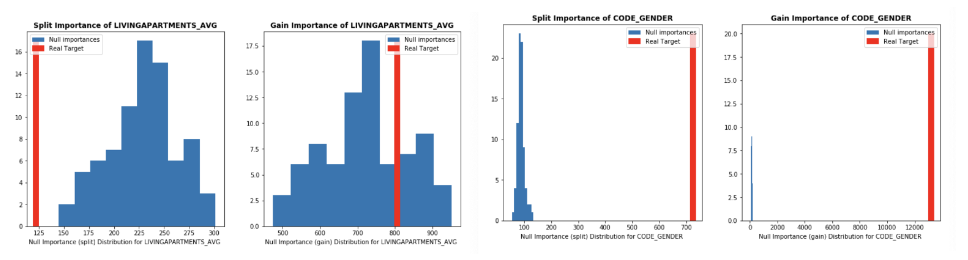

In [26]:
# Original model의 importance를 도출해보겠습니다.

# Decision tree를 이용해 train/test data를 분류하도록 학습합니다.
dt = DecisionTreeRegressor(max_depth=10,       # 트리의 깊이를 규제합니다.
                                  random_state=1214,  # 트리의 랜덤시드를 설정합니다.
                                  min_samples_split=100) # 해당하는 샘플이 100개 이상이면 split하도록 합니다.
dt.fit(X_train, Y_train)
original_FI = dt.feature_importances_

In [27]:
# original feature importance는 아래와 같습니다.
ser = pd.Series(original_FI, index=list(X_train.columns))

In [28]:
# 이제 target 변수를 임의로 permutation 해서, feature importance의 분포를 도출해보겠습니다.
ITER = 20 # 20번 반복
new_FIs = []

for _ in tqdm(range(ITER)) :
    new_y_train = np.random.permutation(Y_train)

    # 앞선 트리모델을 그대로 이용합니다.
    dt = DecisionTreeRegressor(
        max_depth=10, # 트리의 깊이를 규제합니다.
        random_state=1214, # 트리의 랜덤시드를 설정합니다.
        min_samples_split=100) # 해당하는 샘플이 100개 이상이면 split하도록 합니다.

    # 셔플된 새로운 타겟 변수로 모델을 적합합니다.
    dt.fit(X_train, new_y_train)
    new_FIs.append(dt.feature_importances_)          # 새로운 feautre importance들을 수집합니다.

100%|███████████████████████████████████████████| 20/20 [03:58<00:00, 11.95s/it]


In [29]:
np.array(new_FIs).shape       # 셔플된 피쳐별 모음입니다.

(20, 41)

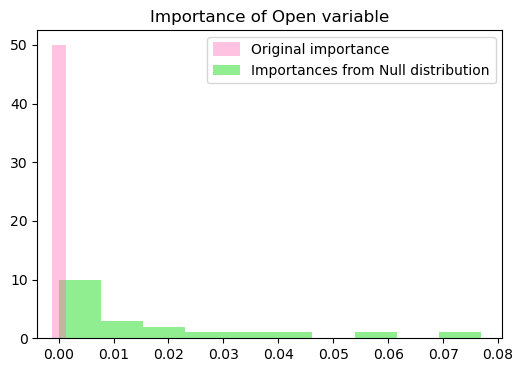

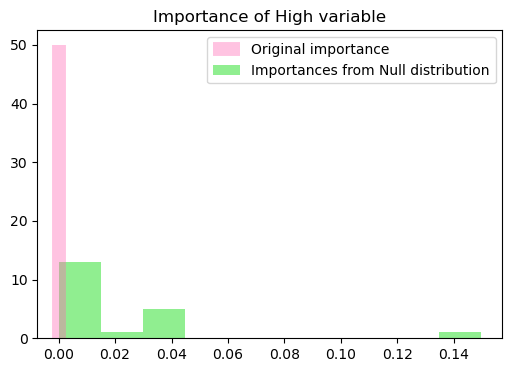

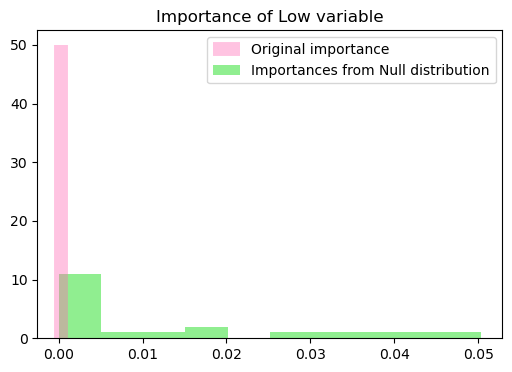

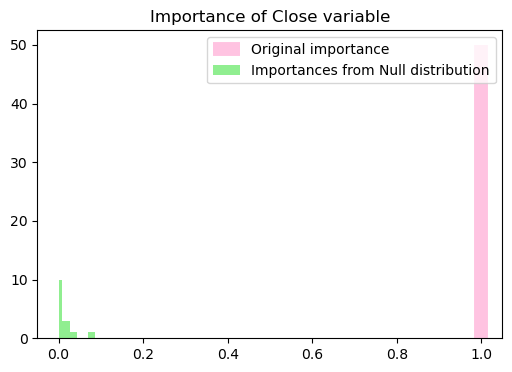

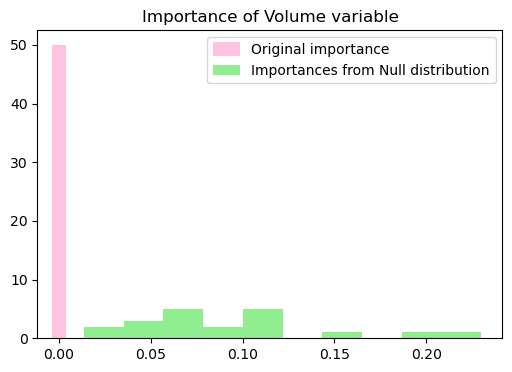

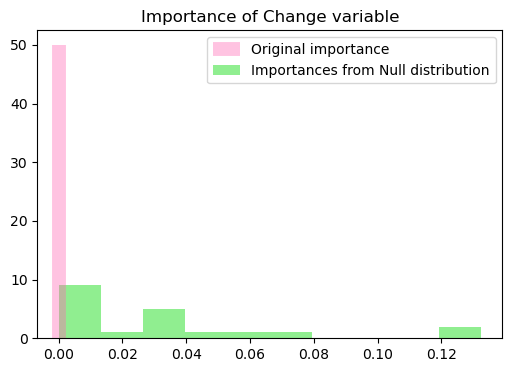

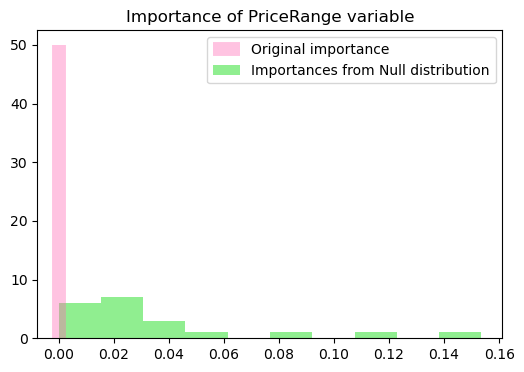

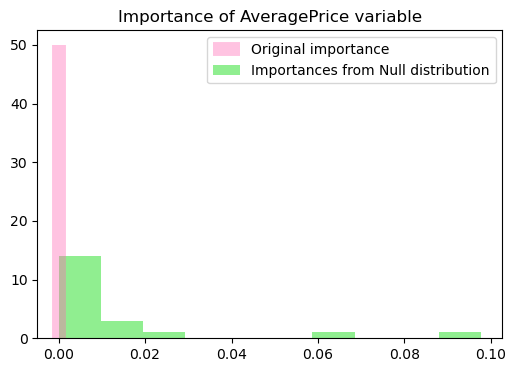

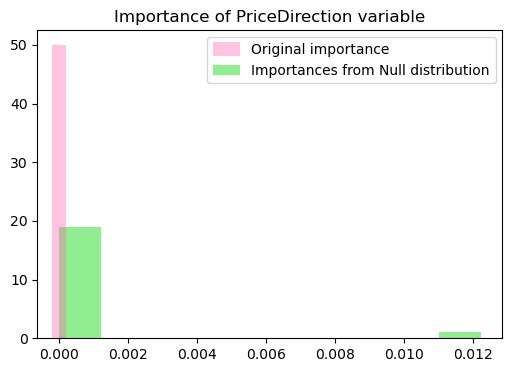

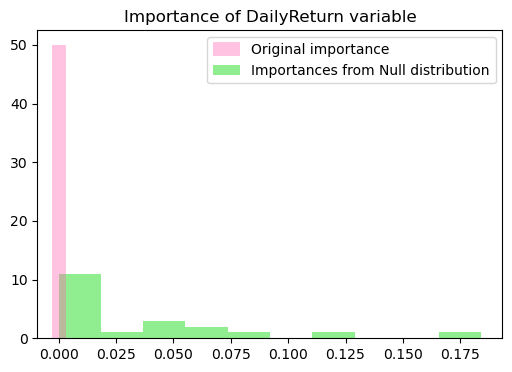

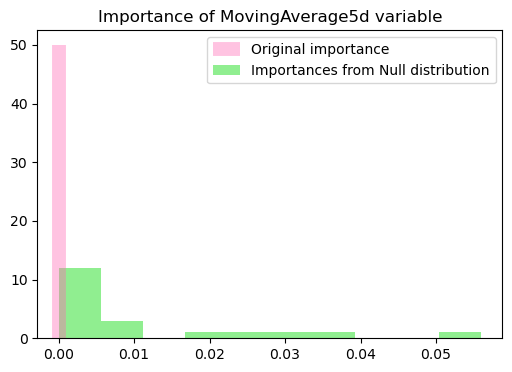

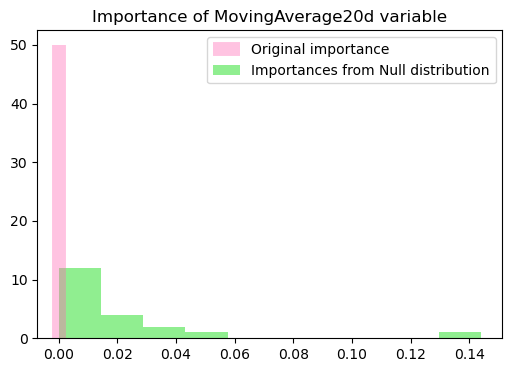

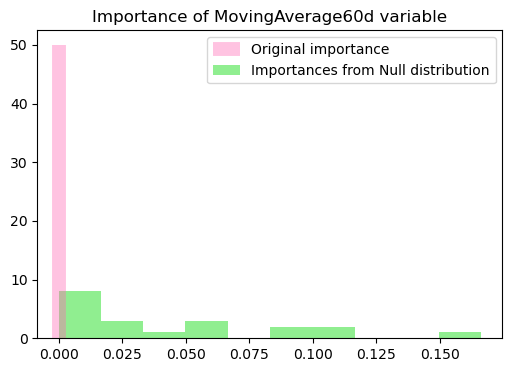

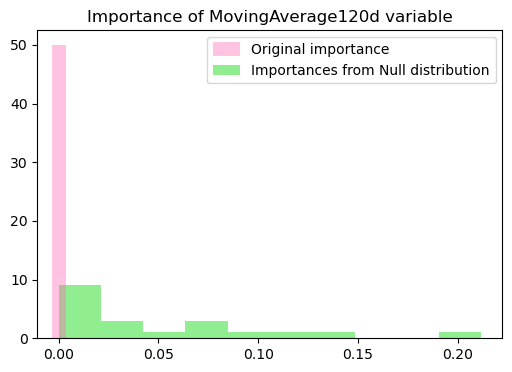

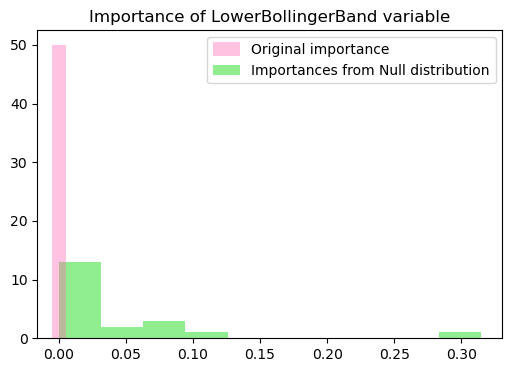

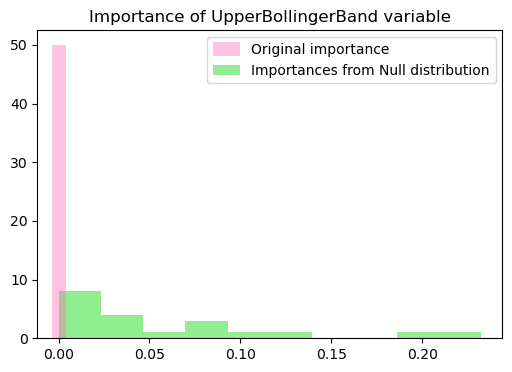

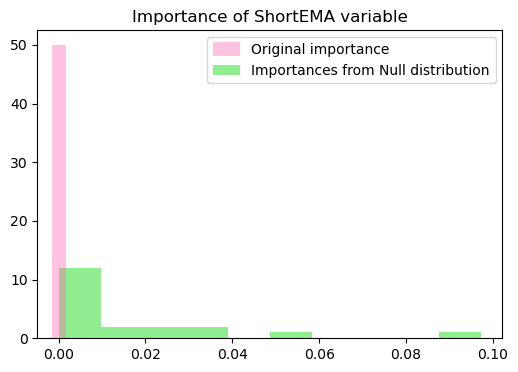

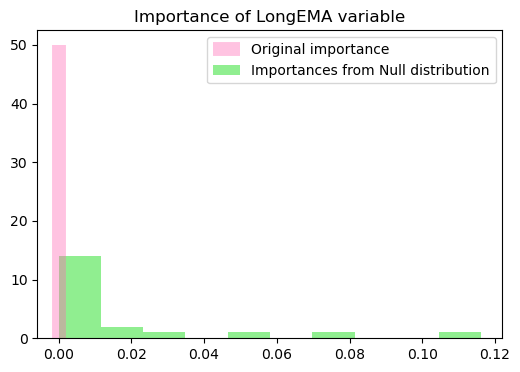

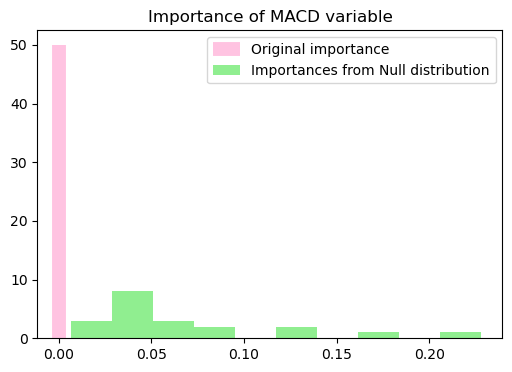

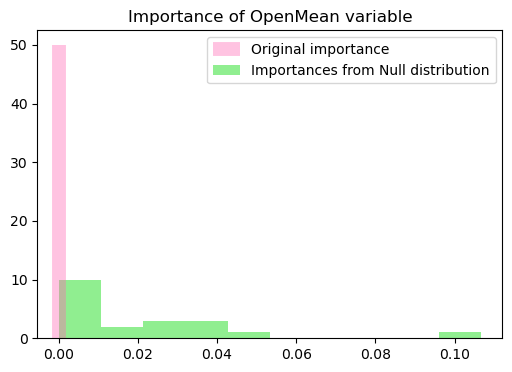

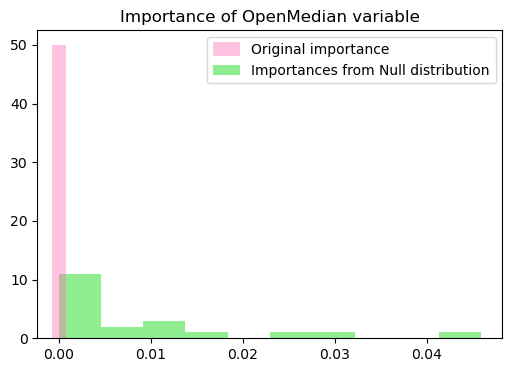

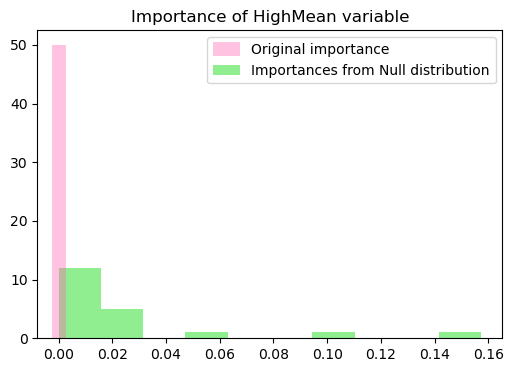

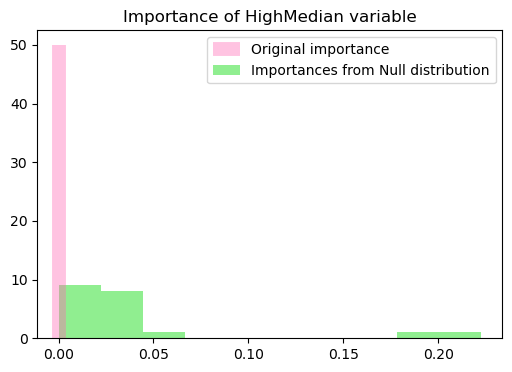

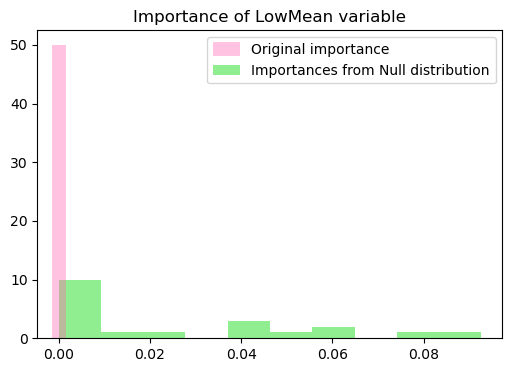

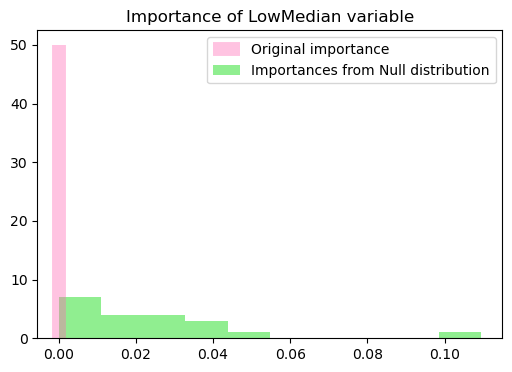

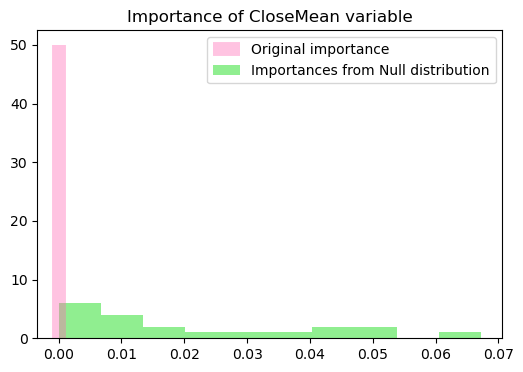

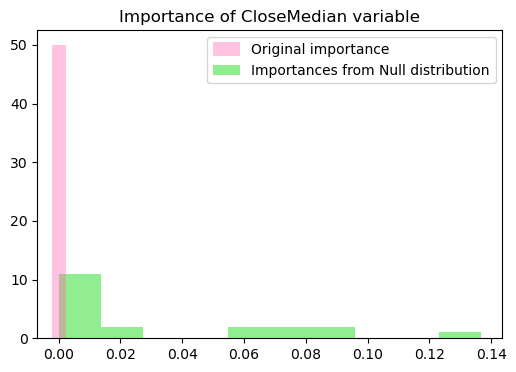

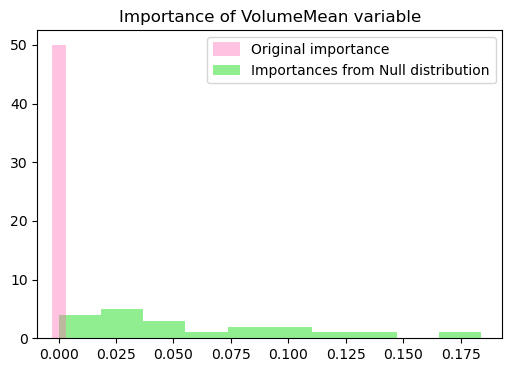

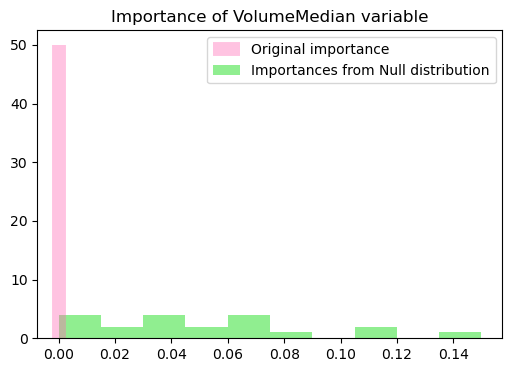

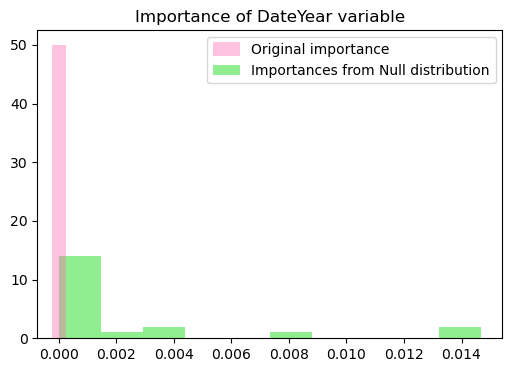

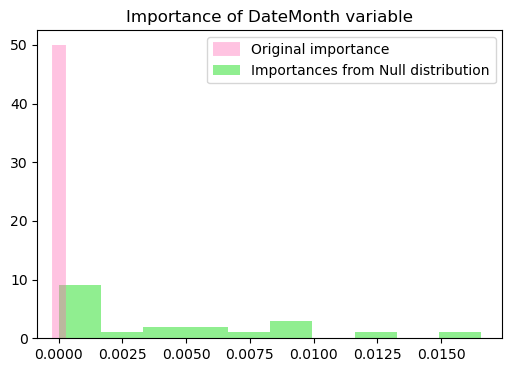

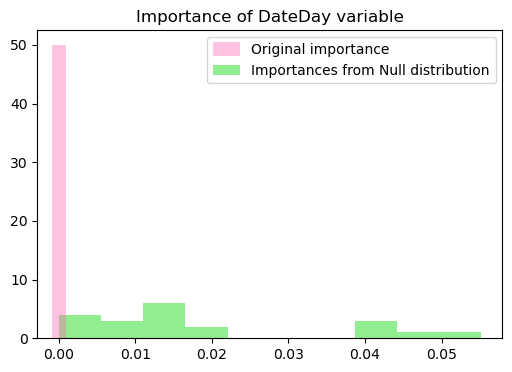

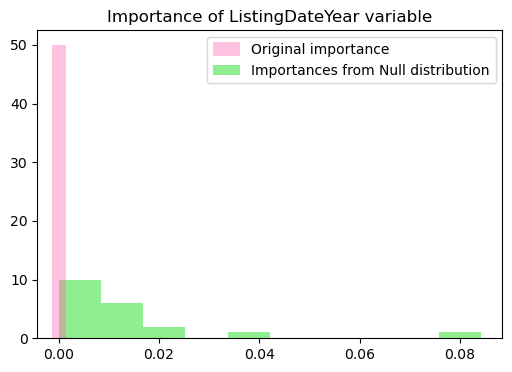

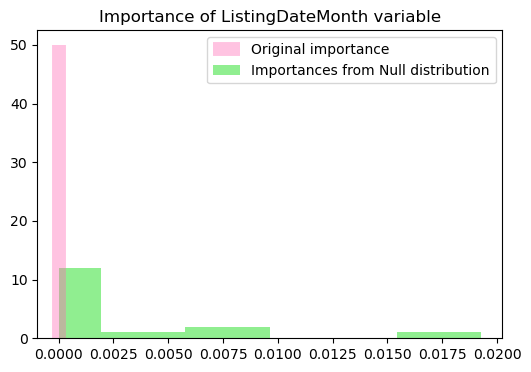

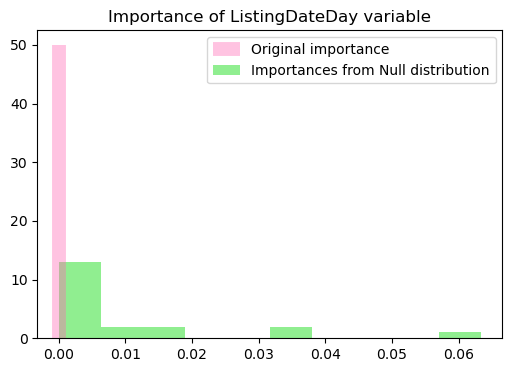

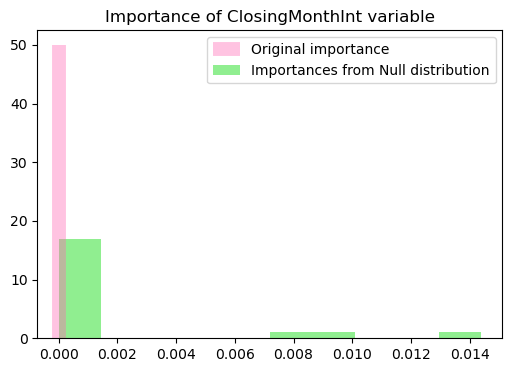

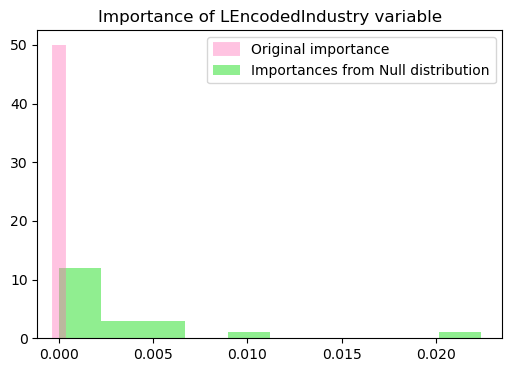

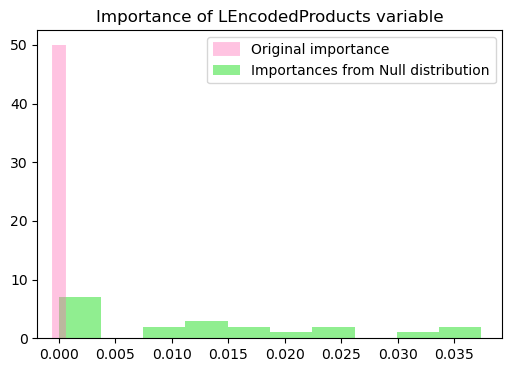

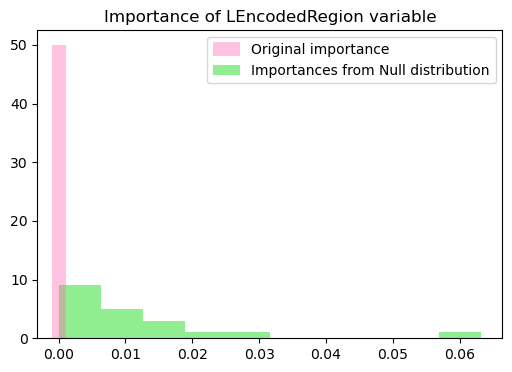

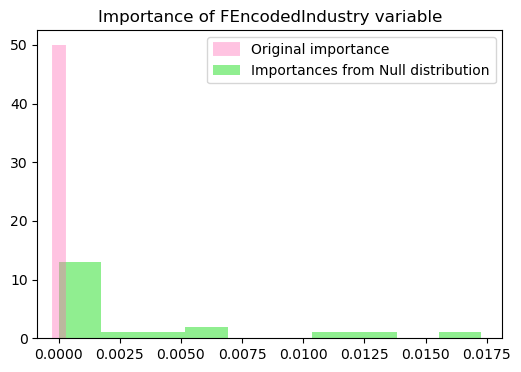

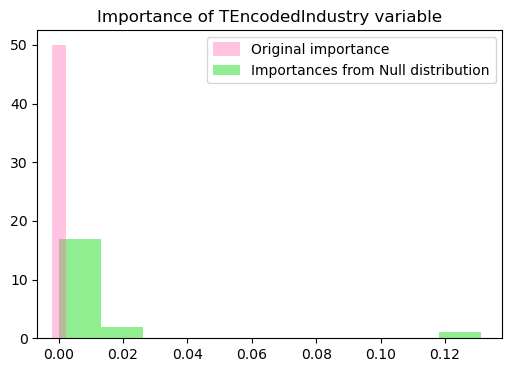

In [30]:
# 변수별로 null importance plot을 그리면 아래와 같습니다.
new_FIs = np.array(new_FIs)

for i in range(len(list(X_train.columns))) :
  ori = original_FI[i]
  new = new_FIs[:, i]

  cur_feat = list(X_train.columns)[i]

  plt.figure(figsize=(6, 4))
  plt.vlines(x=ori, color='hotpink', ymin=0, ymax=50, linewidth=10, label='Original importance', alpha=0.4)
  plt.hist(new, color='lightgreen', label='Importances from Null distribution')
  plt.title('Importance of ' + cur_feat + ' variable')
  plt.legend()
  plt.show()

- 특히 Close 변수의 경우 Null distribution과 굉장히 많이 떨어져있는 모습을 보입니다. 따라서 가장 유의한 변수라고 할 수 있습니다.
- 또한 MACD, Volumn 변수도 null distribution과 겹치지 않으므로, 꽤 유의한 변수라고 할 수 있습니다.

- 따라서 Target permutation으로는 Close, MACD, Volumn, PriceRange, VolumeMean 변수를 선택하도록 하겠습니다. 이들을 이용해 Decision Tree를 적합하면 아래와 같습니다.


In [31]:
# 의사결정트리 분류기를 새로 초기화하고 중요한 특성만 사용하여 훈련합니다.
TP_X_train = X_train[['Close', 'MACD', 'PriceRange', 'Volume', 'VolumeMean']]
TP_X_test = X_valid[['Close', 'MACD', 'PriceRange', 'Volume', 'VolumeMean']]

start_time = time.time()
dt2 = DecisionTreeRegressor(max_depth=10, random_state=1214,min_samples_split=100)
dt2.fit(TP_X_train, Y_train)
y_pred = dt2.predict(TP_X_test)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"변수 선택 후 코드 실행 시간: {elapsed_time} 초")
y_true = Y_valid

# 제곱근 평균 제곱 오차 (RMSE) 계산
rmse = mean_squared_error(y_true, y_pred, squared=False)
print("변수 선택 후 RMSE:", rmse)

변수 선택 후 코드 실행 시간: 1.7757160663604736 초
변수 선택 후 RMSE: 2405.8291805851577


**Adversarial Validation**
- Train data와 Test data가 얼마나 유사한지 판단하는 방법
- Train data의 target 값은 1로, Test data는 0으로 지정 후 binary classification model을 만들어 모델링

> 만약 Train Test data의 경향이 비슷하다면, 위 모델의 분류 성능은 낮을 것
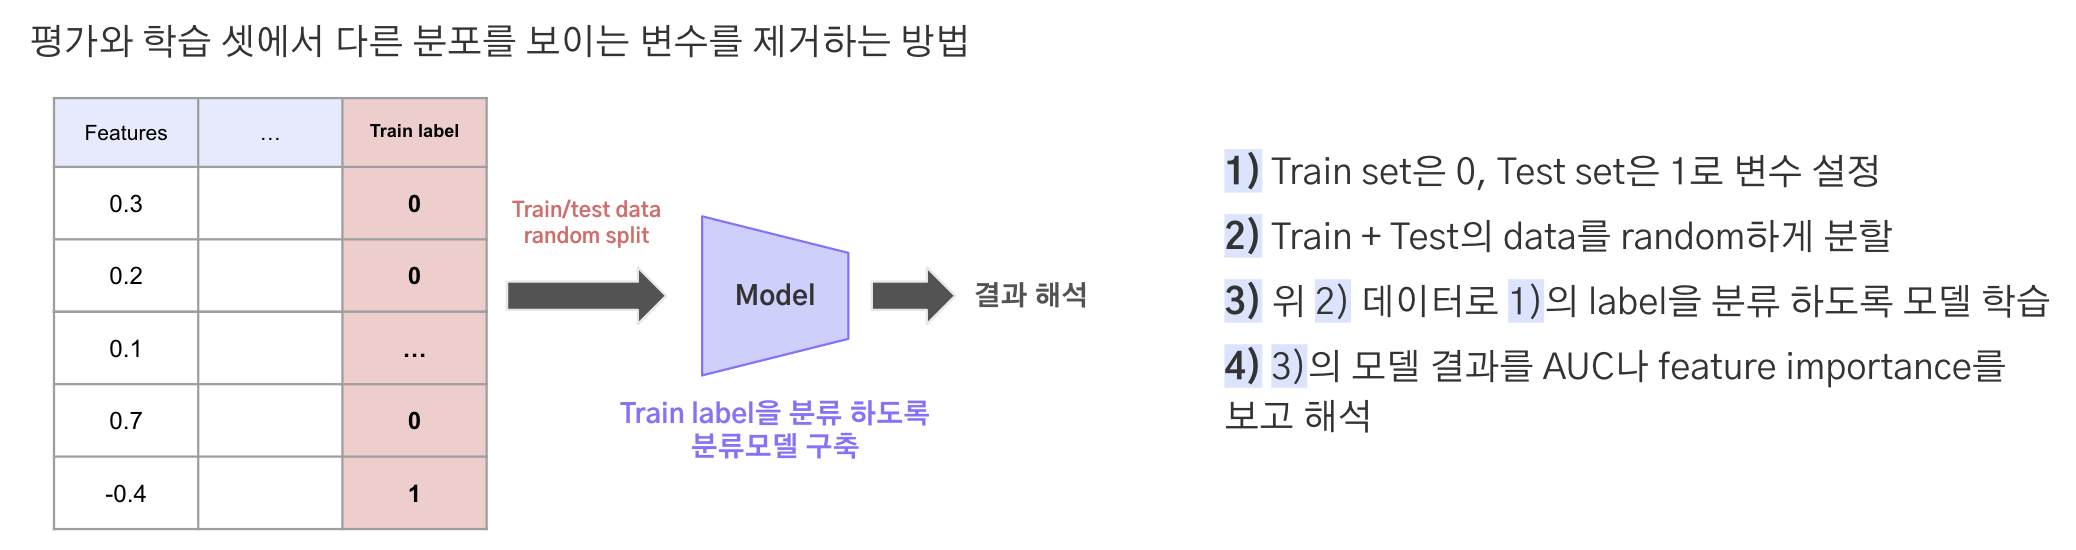

>**참고로 시계열 데이터로 data split을 시간에 따라 진행했기 때문에, 날짜 관련 변수는 제외해 주어야 한다는 것을 유의하세요!**
만약 날짜 관련 변수를 포함하면 아래와 같이 importance가 지배적으로 나오게 됩니다. 아래 결과로 보아, Date 년/월 관련 변수가 train과 test 구분에 굉장히 유의하게 출력됨을 알 수 있습니다. 이는 train/test split을 할 때, 시계열 데이터임에 따라 날짜로 구분했기 때문에 발생하는 자연스러운 현상입니다. 따라서 overfitting 방지를 위해서는 Date 관련 변수는 Adversarial Validation 의미에 따라 제외하는 것이 좋을 수 있습니다.
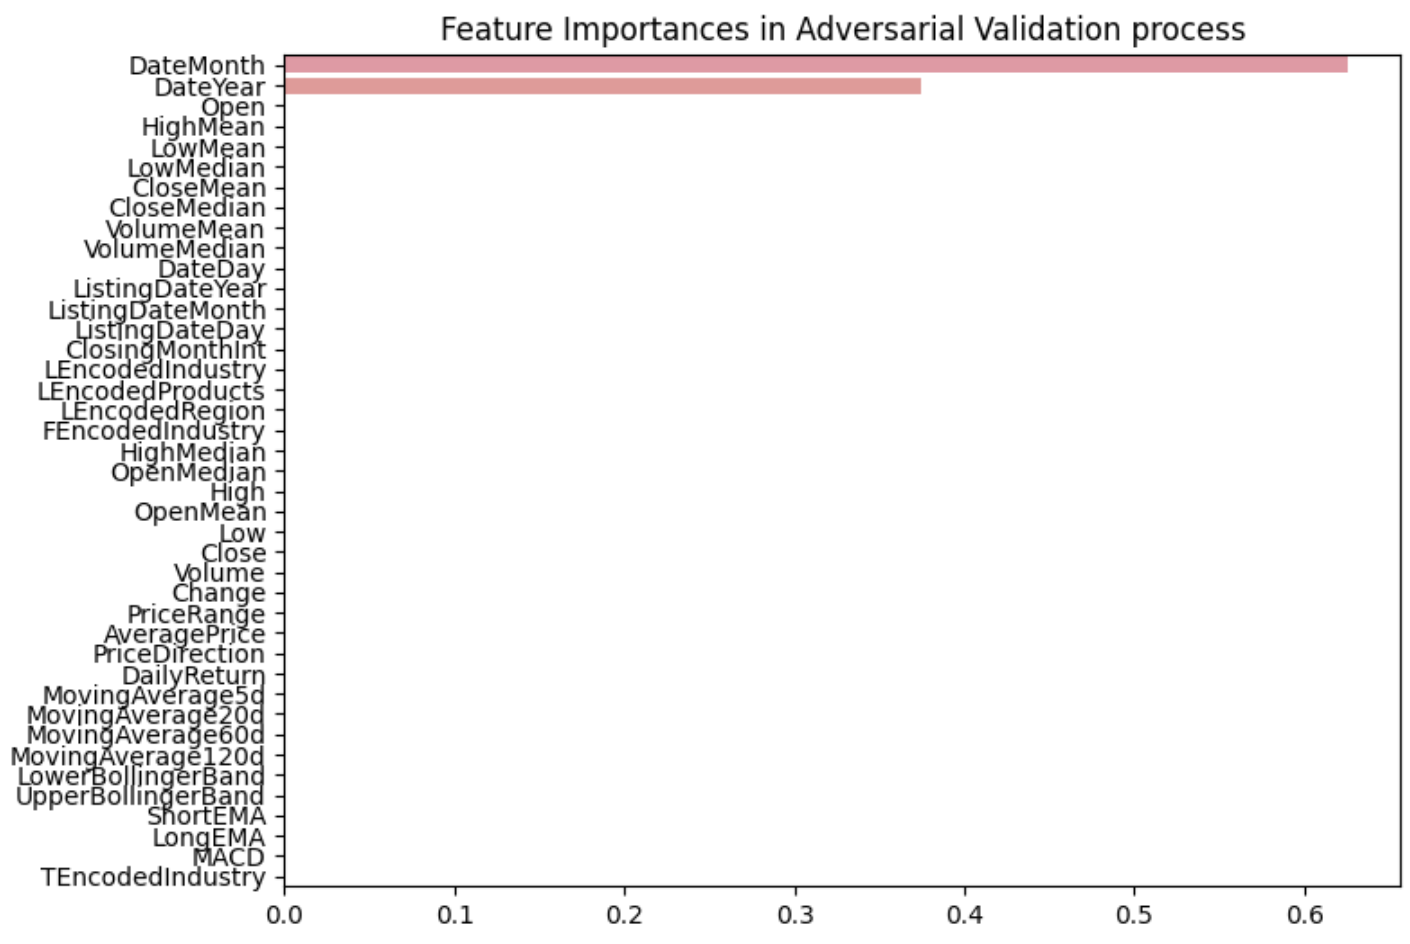

- 기준을 Feature importance로 설정하고, 아래 과정을 실습해보겠습니다.

In [32]:
# Train은 0, Test는 1로 라벨 변수를 설정합니다.
X_train['AV_label'] = 0
X_valid['AV_label'] = 1

# 위 두 데이터를 합치고, 셔플합니다.
all_data = pd.concat([X_train, X_valid], axis=0, ignore_index=True)
all_data_shuffled = all_data.sample(frac=1)
X = all_data_shuffled.drop(['AV_label', 'DateYear', 'DateMonth'], axis=1)      # Date 관련 변수도 제외해 주는 것을 기억하세요!
y = all_data_shuffled['AV_label']

In [33]:
X.columns      # 아래와 같은 column을 이용합니다.

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'PriceRange',
       'AveragePrice', 'PriceDirection', 'DailyReturn', 'MovingAverage5d',
       'MovingAverage20d', 'MovingAverage60d', 'MovingAverage120d',
       'LowerBollingerBand', 'UpperBollingerBand', 'ShortEMA', 'LongEMA',
       'MACD', 'OpenMean', 'OpenMedian', 'HighMean', 'HighMedian', 'LowMean',
       'LowMedian', 'CloseMean', 'CloseMedian', 'VolumeMean', 'VolumeMedian',
       'DateDay', 'ListingDateYear', 'ListingDateMonth', 'ListingDateDay',
       'ClosingMonthInt', 'LEncodedIndustry', 'LEncodedProducts',
       'LEncodedRegion', 'FEncodedIndustry', 'TEncodedIndustry'],
      dtype='object')

In [34]:
# Decision tree를 이용해 Train/Test data를 분류하도록 학습합니다.
from sklearn.tree import DecisionTreeClassifier
dt_adv = DecisionTreeClassifier(random_state=0)
dt_adv.fit(X, y)
ytrainpredict_rf = dt_adv.predict(X)

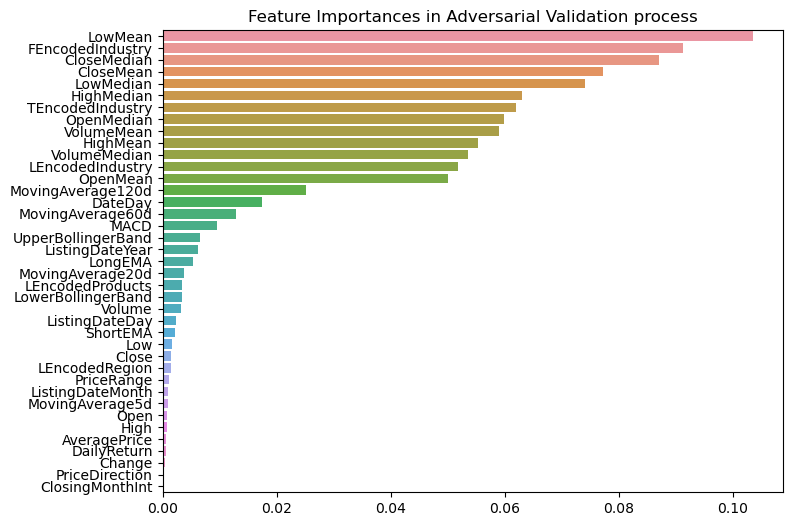

In [35]:
# 위 feature importance를 시각화해봅니다.
ser = pd.Series(dt_adv.feature_importances_, index=list(X.columns))
top15 = ser.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title("Feature Importances in Adversarial Validation process")
sns.barplot(x=top15, y=top15.index)
plt.show()

- 여기서 Feature importance가 높은 변수들은 학습과 테스트 데이터셋을 구분하는데 가장 크게 기여하는 변수들이라고 할 수 있습니다.
- 이는 학습과 테스트 데이터셋에서 서로 다른 분포를 지닌 변수들이라고 할 수 있고, 제거하는 것이 과적합 방지에 도움을 줄 수 있다는 뜻입니다.

- 위에서 선택된 변수들을 제거하고, 모델을 학습해보겠습니다. 모델은 DecisionTree를 이용하겠습니다.

In [36]:
# 위 train/test 분류의 importance가 0.003 이하인 변수들만 가지고 학습하도록 하겠습니다.
# 이 변수들은 그나마 train과 test 분류에 기여하지 못하는(=train, test 분포가 비슷한) 변수들이라고 해석할 수 있습니다.

av_choosed = pd.DataFrame(ser, columns=['imp']).query('imp<0.003').reset_index()
av_choosed

,index,imp
0,Open,0.000831
1,High,0.000697
2,Low,0.001622
3,Close,0.001453
4,Change,0.000418
5,PriceRange,0.001188
6,AveragePrice,0.000638
7,PriceDirection,0.000016
8,DailyReturn,0.000548
9,MovingAverage5d,0.000917


In [37]:
# 의사결정트리 분류기를 새로 초기화하고 중요한 특성만 사용하여 훈련합니다.
TP_X_train = X_train[list(av_choosed['index'])]
TP_X_test = X_valid[list(av_choosed['index'])]

start_time = time.time()
dt2 = DecisionTreeRegressor(max_depth=10, random_state=1214,min_samples_split=100)
dt2.fit(TP_X_train, Y_train)
y_pred = dt2.predict(TP_X_test)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"변수 선택 후 코드 실행 시간: {elapsed_time} 초")
y_true = Y_valid

# 제곱근 평균 제곱 오차 (RMSE) 계산
rmse = mean_squared_error(y_true, y_pred, squared=False)
print("변수 선택 후 RMSE:", rmse)

변수 선택 후 코드 실행 시간: 3.281831979751587 초
변수 선택 후 RMSE: 2416.8115584394955



### Summary
- 지금까지 여러가지 변수 선택 방법을 실습해 보았습니다. 이들을 한번에 정리해보면 아래와 같습니다.
- 사용한 모델은 DecisionTree Regressor로 통일하겠습니다. (아래 방법은 선택된 feature들만 변경된 것입니다.)


In [38]:
# |변수 선택 방법|선택된 Feature 수|학습 & 추론속도|성능(RMSE)| 선택된 Feature |
# |:---|:---:| :------- : |  :------: | ------ |
# |원본 모델(전체 변수 포함)|41(원래 feature 수)|30.78 s|2517.73 |     |
# |Forward selection |1| 0.84 s | 2224.65 |Close|
# |Feature Importance 기반 selection|11 | 8.08s  | 2401.24  | Close, Change, MACD, DateMonth, High, VolumeMean, Low, DateDay, Volume, PriceRange, AveragePrice |
# |Permutation Importance 기반 selection|1| 0.84 s | 2224.65 | Close |
# |Target permutation 기반 selection| 5 |3.3s | 2405.83 | Close, MACD, Volumn, PriceRange, VolumeMean|
# |Adversarial Validation 기반 selection|15| 8.559 s | 2416.81 | Close, Open, High, Low, PriceRange 외 10개의 변수  |

#Reference
- [이론 자료](https://docs.google.com/presentation/d/1evYllxHKpPqHb9c27tb-mh0xXEAqSJvXfGFL3HT3BwU/edit)


## Required Package

> eli5==0.11.0 <br>
gdown==4.7.1


